# Preparing Alpha Factors and Features to Predict Stock Returns

## Imports & Settings

In [268]:
import warnings
warnings.filterwarnings('ignore')

In [269]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from scipy.stats import pearsonr, spearmanr
from talib import RSI, BBANDS, MACD, ATR

In [270]:
MONTH = 21
YEAR = 12 * MONTH

In [271]:
START = '1962-01-01'
END = '2019-12-01'

In [272]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

## Loading YFinance Stock Prices & US Equities Meta Data

In [380]:
ohlcv = ['open', 'close', 'low', 'high', 'volume']

In [381]:
DATA_STORE = '../data/assets.h5'

In [387]:
with pd.HDFStore(DATA_STORE) as store:
    prices = (store['stocks/yfinance/prices']
              .sort_index(level=0)
              .loc[idx[START:END, :], ohlcv]
              .assign(volume=lambda x: x.volume.div(1000))
              .swaplevel())
    stocks = (store['stocks/quandl/metadata'])

In [388]:
prices

,,open,close,low,high,volume
ticker,date,,,,,
BA,1962-01-02,0.194272,0.190931,0.190931,0.194272,352.350
BP,1962-01-02,0.000000,0.051924,0.051924,0.052635,77.440
GE,1962-01-02,0.789086,0.786456,0.781195,0.802238,345.317
MMM,1962-01-02,0.000000,0.745309,0.739705,0.762120,212.800
BA,1962-01-03,0.193795,0.194749,0.193795,0.197614,710.775
...,...,...,...,...,...,...
SNY,2019-11-29,41.640974,41.730370,41.605215,41.792947,590.600
T,2019-11-29,21.771049,21.563375,21.551839,21.897960,24060.390
TM,2019-11-29,140.149994,140.210007,140.070007,140.580002,107.800


## Remove stocks with few observations

In [389]:
# we want at least 2 years of data
min_obs = 2 * YEAR

# have this much per ticker 
nobs = prices.groupby(level='ticker').size()

# keep those that exceed the limit
keep = nobs[nobs > min_obs].index

prices = prices.loc[idx[keep, :], :]
prices.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 194830 entries, ('AAPL', Timestamp('1980-12-12 00:00:00')) to ('WMT', Timestamp('2019-11-29 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   open    194830 non-null  float64
 1   close   194830 non-null  float64
 2   low     194830 non-null  float64
 3   high    194830 non-null  float64
 4   volume  194830 non-null  float64
dtypes: float64(5)
memory usage: 8.6+ MB


### Align price and meta data

In [390]:
stocks = stocks[~stocks.index.duplicated() & stocks.sector.notnull()]
stocks.sector = stocks.sector.str.lower().str.replace(' ', '_')
stocks.index.name = 'ticker'

In [391]:
shared = (prices.index.get_level_values('ticker').unique()
          .intersection(stocks.index))
stocks = stocks.loc[shared, :]
prices = prices.loc[idx[shared, :], :]

In [392]:
prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 194830 entries, ('AAPL', Timestamp('1980-12-12 00:00:00')) to ('WMT', Timestamp('2019-11-29 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   open    194830 non-null  float64
 1   close   194830 non-null  float64
 2   low     194830 non-null  float64
 3   high    194830 non-null  float64
 4   volume  194830 non-null  float64
dtypes: float64(5)
memory usage: 8.6+ MB


In [393]:
stocks.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 21 entries, AAPL to WMT
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       21 non-null     object 
 1   lastsale   21 non-null     float64
 2   marketcap  21 non-null     float64
 3   ipoyear    7 non-null      float64
 4   sector     21 non-null     object 
 5   industry   21 non-null     object 
dtypes: float64(3), object(3)
memory usage: 1.1+ KB


In [394]:
stocks.sector.value_counts()

technology               7
capital_goods            3
consumer_services        2
energy                   2
health_care              2
finance                  1
basic_industries         1
miscellaneous            1
consumer_non-durables    1
public_utilities         1
Name: sector, dtype: int64

Optional: persist intermediate results:

In [395]:
# with pd.HDFStore('tmp.h5') as store:
#     store.put('prices', prices)
#     store.put('stocks', stocks)

In [396]:
# with pd.HDFStore('tmp.h5') as store:
#     prices = store['prices']
#     stocks = store['stocks']

## Compute Rolling Average Dollar Volume

In [397]:
# compute dollar volume to determine universe
prices['dollar_vol'] = prices[['close', 'volume']].prod(axis=1)

In [398]:
prices['dollar_vol_1m'] = (prices.dollar_vol.groupby('ticker')
                           .rolling(window=21)
                           .mean()).values

In [399]:
prices.head()

open     close       low      high    volume  \
ticker date                                                           
AAPL   1980-12-12  0.099874  0.099874  0.099874  0.100308  469033.6   
       1980-12-15  0.095098  0.094663  0.094663  0.095098  175884.8   
       1980-12-16  0.088149  0.087715  0.087715  0.088149  105728.0   
       1980-12-17  0.089886  0.089886  0.089886  0.090321   86441.6   
       1980-12-18  0.092492  0.092492  0.092492  0.092927   73449.6   

                     dollar_vol  dollar_vol_1m  
ticker date                                     
AAPL   1980-12-12  46844.159144            NaN  
       1980-12-15  16649.843384            NaN  
       1980-12-16   9273.955143            NaN  
       1980-12-17   7769.915613            NaN  
       1980-12-18   6793.522239            NaN

In [400]:
prices['dollar_vol_rank'] = (prices.groupby('date')
                             .dollar_vol_1m
                             .rank(ascending=False))

In [401]:
prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 194830 entries, ('AAPL', Timestamp('1980-12-12 00:00:00')) to ('WMT', Timestamp('2019-11-29 00:00:00'))
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   open             194830 non-null  float64
 1   close            194830 non-null  float64
 2   low              194830 non-null  float64
 3   high             194830 non-null  float64
 4   volume           194830 non-null  float64
 5   dollar_vol       194830 non-null  float64
 6   dollar_vol_1m    194410 non-null  float64
 7   dollar_vol_rank  194410 non-null  float64
dtypes: float64(8)
memory usage: 13.1+ MB


## Add some Basic Factors

### Compute the Relative Strength Index

In [402]:
prices['rsi'] = prices.groupby(level='ticker').close.apply(RSI)

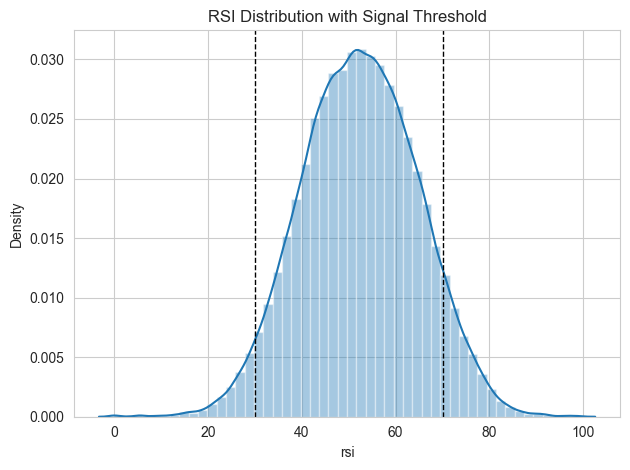

In [403]:
ax = sns.distplot(prices.rsi.dropna())
ax.axvline(30, ls='--', lw=1, c='k')
ax.axvline(70, ls='--', lw=1, c='k')
ax.set_title('RSI Distribution with Signal Threshold')
plt.tight_layout();

### Compute Bollinger Bands

In [404]:
def compute_bb(close):
    high, mid, low = BBANDS(close, timeperiod=20)
    return pd.DataFrame({'bb_high': high, 'bb_low': low}, index=close.index)

In [405]:
prices = (prices.join(prices
                      .groupby(level='ticker')
                      .close
                      .apply(compute_bb)))

In [406]:
prices['bb_high'] = prices.bb_high.sub(prices.close).div(prices.bb_high).apply(np.log1p)
prices['bb_low'] = prices.close.sub(prices.bb_low).div(prices.close).apply(np.log1p)

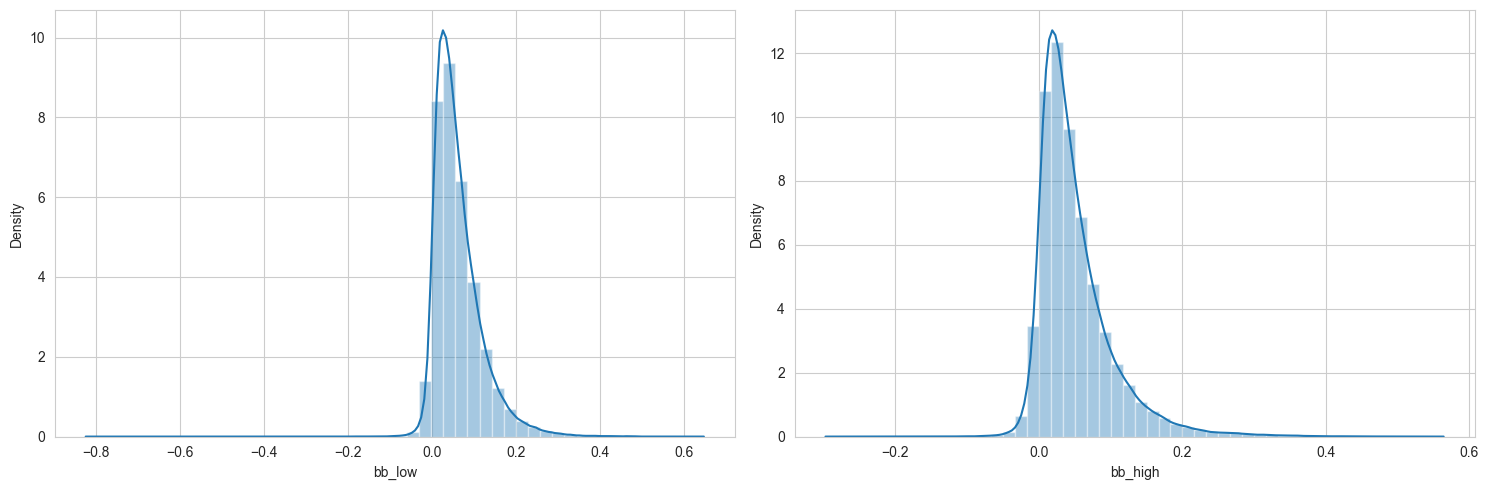

In [407]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
sns.distplot(prices.loc[prices.dollar_vol_rank<100, 'bb_low'].dropna(), ax=axes[0])
sns.distplot(prices.loc[prices.dollar_vol_rank<100, 'bb_high'].dropna(), ax=axes[1])
plt.tight_layout();

### Compute Average True Range

In [408]:
def compute_atr(stock_data):
    df = ATR(stock_data.high, stock_data.low, 
             stock_data.close, timeperiod=14)
    return df.sub(df.mean()).div(df.std())

In [409]:
prices['atr'] = (prices.groupby('ticker', group_keys=False)
                 .apply(compute_atr))

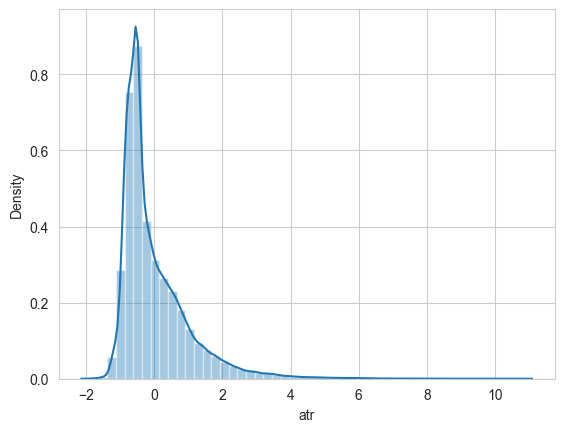

In [410]:
sns.distplot(prices[prices.dollar_vol_rank<50].atr.dropna());

### Compute Moving Average Convergence/Divergence

In [411]:
def compute_macd(close):
    macd = MACD(close)[0]
    return (macd - np.mean(macd))/np.std(macd)

In [412]:
prices['macd'] = (prices
                  .groupby('ticker', group_keys=False)
                  .close
                  .apply(compute_macd))

In [413]:
prices.macd.describe(percentiles=[.001, .01, .02, .03, .04, .05, .95, .96, .97, .98, .99, .999]).apply(lambda x: f'{x:,.1f}')

count    194,137.0
mean           0.0
std            1.0
min          -11.7
0.1%          -6.6
1%            -3.1
2%            -2.3
3%            -1.9
4%            -1.6
5%            -1.4
50%           -0.1
95%            1.5
96%            1.8
97%            2.0
98%            2.4
99%            3.2
99.9%          6.1
max           13.2
Name: macd, dtype: object

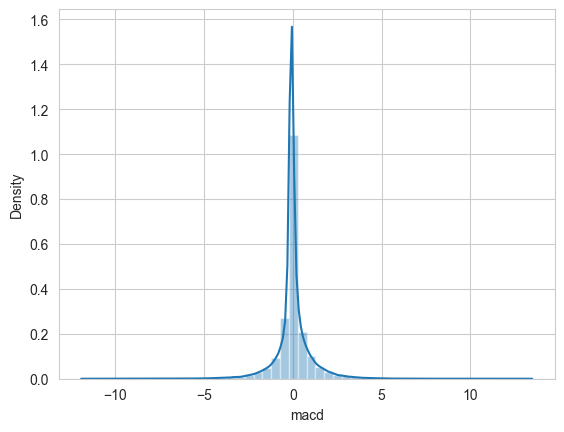

In [414]:
sns.distplot(prices[prices.dollar_vol_rank<100].macd.dropna());

## Compute Lagged Returns

In [415]:
lags = [1, 5, 10, 21, 42, 63]

In [416]:
returns = prices.groupby(level='ticker').close.pct_change()
percentiles=[.0001, .001, .01]
percentiles+= [1-p for p in percentiles]
returns.describe(percentiles=percentiles).iloc[2:].to_frame('percentiles').style.format(lambda x: f'{x:,.2%}')

,percentiles
std,2.22%
min,-51.87%
0.01%,-21.15%
0.1%,-11.82%
1%,-5.88%
50%,0.00%
99%,6.42%
99.9%,13.99%
99.99%,24.24%
max,50.00%


In [417]:
q = 0.0001

### Winsorize outliers

In [418]:
for lag in lags:
    prices[f'return_{lag}d'] = (prices.groupby(level='ticker').close
                                .pct_change(lag)
                                .pipe(lambda x: x.clip(lower=x.quantile(q),
                                                       upper=x.quantile(1 - q)))
                                .add(1)
                                .pow(1 / lag)
                                .sub(1)
                                )

### Shift lagged returns

In [419]:
for t in [1, 2, 3, 4, 5]:
    for lag in [1, 5, 10, 21]:
        prices[f'return_{lag}d_lag{t}'] = (prices.groupby(level='ticker')
                                           [f'return_{lag}d'].shift(t * lag))

## Compute Forward Returns

In [420]:
for t in [1, 5, 10, 21]:
    prices[f'target_{t}d'] = prices.groupby(level='ticker')[f'return_{t}d'].shift(-t)

## Combine Price and Meta Data

In [421]:
prices = prices.join(stocks[['sector']])

## Create time and sector dummy variables

In [422]:
prices['year'] = prices.index.get_level_values('date').year
prices['month'] = prices.index.get_level_values('date').month

In [423]:
prices.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 194830 entries, ('AAPL', Timestamp('1980-12-12 00:00:00')) to ('WMT', Timestamp('2019-11-29 00:00:00'))
Data columns (total 46 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   open             194830 non-null  float64
 1   close            194830 non-null  float64
 2   low              194830 non-null  float64
 3   high             194830 non-null  float64
 4   volume           194830 non-null  float64
 5   dollar_vol       194830 non-null  float64
 6   dollar_vol_1m    194410 non-null  float64
 7   dollar_vol_rank  194410 non-null  float64
 8   rsi              194536 non-null  float64
 9   bb_high          194431 non-null  float64
 10  bb_low           194431 non-null  float64
 11  atr              194536 non-null  float64
 12  macd             194137 non-null  float64
 13  return_1d        194809 non-null  float64
 14  return_5d        194725 non-null  float64
 15  return_10

In [424]:
prices.assign(sector=pd.factorize(prices.sector, sort=True)[0]).to_hdf('data.h5', 'model_data/no_dummies')

In [425]:
prices = pd.get_dummies(prices,
                        columns=['year', 'month', 'sector'],
                        prefix=['year', 'month', ''],
                        prefix_sep=['_', '_', ''],
                        drop_first=True)

In [426]:
prices.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 194830 entries, ('AAPL', Timestamp('1980-12-12 00:00:00')) to ('WMT', Timestamp('2019-11-29 00:00:00'))
Columns: 120 entries, open to technology
dtypes: float64(43), uint8(77)
memory usage: 83.4+ MB


## Store Model Data

In [427]:
prices.to_hdf('data.h5', 'model_data')

## Explore Data

### Plot Factors

In [428]:
target = 'target_5d'
top100 = prices[prices.dollar_vol_rank<100].copy()

### RSI

In [429]:
top100.loc[:, 'rsi_signal'] = pd.cut(top100.rsi, bins=[0, 30, 70, 100])

In [430]:
top100.groupby('rsi_signal')['target_5d'].describe()

,count,mean,std,min,25%,50%,75%,max
rsi_signal,,,,,,,,
"(0, 30]",6431.0,0.002183,0.012679,-0.084575,-0.003851,0.001558,0.007969,0.084472
"(30, 70]",172615.0,0.000503,0.009643,-0.086664,-0.004158,0.000477,0.005236,0.084472
"(70, 100]",15212.0,0.000287,0.008734,-0.079093,-0.004157,0.000000,0.004270,0.084472


### Bollinger Bands

-2.41% (0.00%)


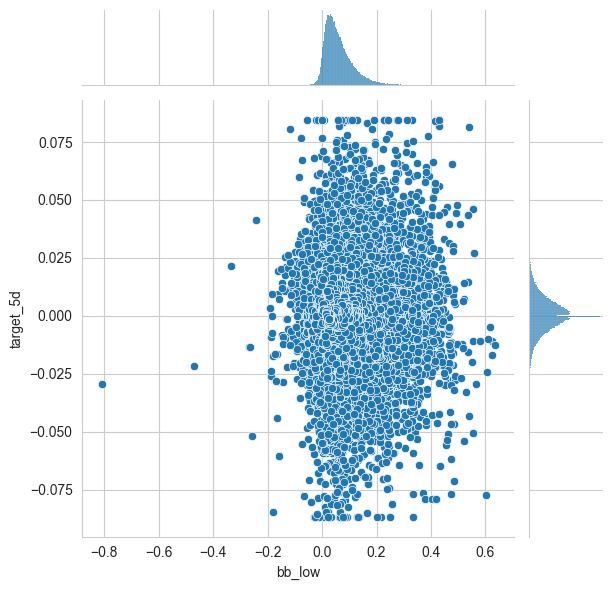

In [431]:
metric = 'bb_low'
j=sns.jointplot(x=metric, y=target, data=top100)

df = top100[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print(f'{r:,.2%} ({p:.2%})')

2.68% (0.00%)


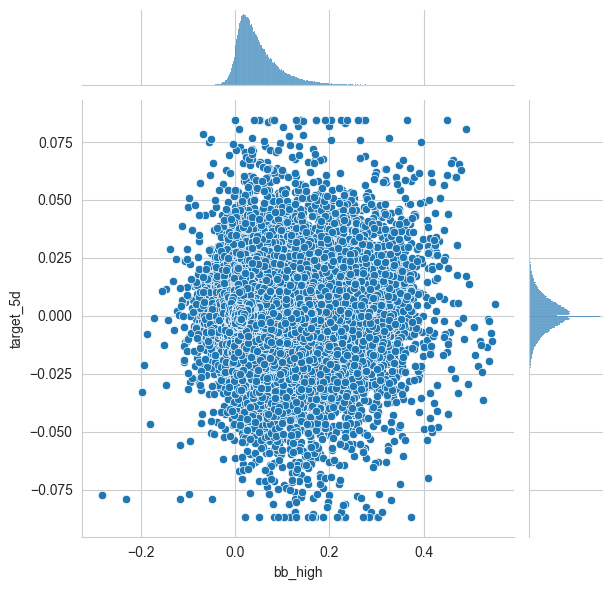

In [432]:
metric = 'bb_high'
j=sns.jointplot(x=metric, y=target, data=top100)

df = top100[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print(f'{r:,.2%} ({p:.2%})')

### ATR

-1.58% (0.00%)


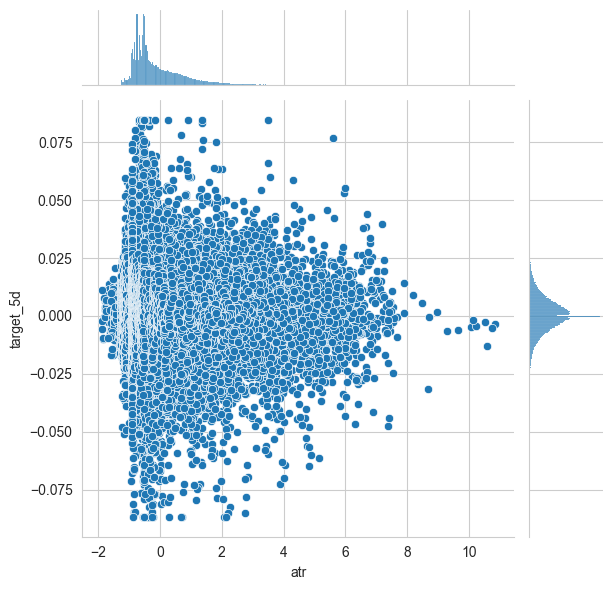

In [433]:
metric = 'atr'
j=sns.jointplot(x=metric, y=target, data=top100)

df = top100[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print(f'{r:,.2%} ({p:.2%})')

### MACD

-1.76% (0.00%)


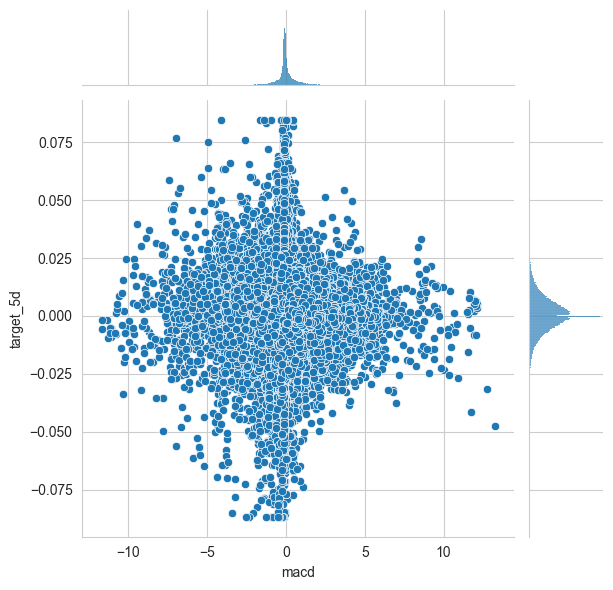

In [434]:
metric = 'macd'
j=sns.jointplot(x=metric, y=target, data=top100)

df = top100[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print(f'{r:,.2%} ({p:.2%})')